# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [26]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [27]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [28]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [29]:
# Load the historical closing prices for bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [30]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [31]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [32]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [33]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 1

# Column index 1 is the `Close` column
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [38]:
#display(X)
#display(y)

In [42]:
# Use 70% of the data for training and the remaineder for testing
def window_data(df, window, feature_col_number, target_col_number): 
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [44]:
# Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 1
target_column = 1

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(df, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[ 9114.719727  8870.820313  9251.269531  8218.049805  6937.080078
   7701.25      7592.720215  8260.69043   8696.830078  8569.290039
   8084.609863  8911.269531  8544.69043   9485.639648 10033.75
  10188.730469 11097.209961 10417.230469 11182.280273 11256.429688
  10481.660156  9847.959961 10175.509766  9705.730469  9610.110352
  10326.5      10594.759766 10334.44043  10929.370117 11043.120117]
 [ 8870.820313  9251.269531  8218.049805  6937.080078  7701.25
   7592.720215  8260.69043   8696.830078  8569.290039  8084.609863
   8911.269531  8544.69043   9485.639648 10033.75     10188.730469
  11097.209961 10417.230469 11182.280273 11256.429688 10481.660156
   9847.959961 10175.509766  9705.730469  9610.110352 10326.5
  10594.759766 10334.44043  10929.370117 11043.120117 11465.360352]
 [ 9251.269531  8218.049805  6937.080078  7701.25      7592.720215
   8260.69043   8696.830078  8569.290039  8084.609863  8911.269531
   8544.69043   9485.639648 10033.75     10188.730469 11

In [45]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split - 1]
X_test = X[split:]

y_train = y[: split - 1]
y_test = y[split:]

In [46]:
# Use MinMaxScaler to scale the data between 0 and 1. 
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [50]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.60761794]
  [0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]
  [0.5012101 ]
  [0.58660203]
  [0.5487353 ]
  [0.64593307]
  [0.70255153]
  [0.71856064]
  [0.81240436]
  [0.74216413]
  [0.82119191]
  [0.82885137]
  [0.74881956]
  [0.68335987]
  [0.71719497]
  [0.66866791]
  [0.65879059]
  [0.7327919 ]
  [0.76050248]
  [0.73361212]
  [0.79506691]
  [0.80681701]]

 [[0.58242373]
  [0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 ]
  [0.5193988 ]
  [0.56445096]
  [0.55127638]
  [0.5012101 ]
  [0.58660203]
  [0.5487353 ]
  [0.64593307]
  [0.70255153]
  [0.71856064]
  [0.81240436]
  [0.74216413]
  [0.82119191]
  [0.82885137]
  [0.74881956]
  [0.68335987]
  [0.71719497]
  [0.66866791]
  [0.65879059]
  [0.7327919 ]
  [0.76050248]
  [0.73361212]
  [0.79506691]
  [0.80681701]
  [0.8504334 ]]

 [[0.62172321]
  [0.51499412]
  [0.38267307]
  [0.46160996]
  [0.4503991 

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [53]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# YOUR CODE HERE!

# Model set-up
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [54]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [55]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 30, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [56]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
# YOUR CODE HERE!
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Train on 357 samples
Epoch 1/10
357/357 [==============================] - 6s 17ms/sample - loss: 0.1149
Epoch 2/10
357/357 [==============================] - 0s 676us/sample - loss: 0.0481
Epoch 3/10
357/357 [==============================] - 0s 695us/sample - loss: 0.0229
Epoch 4/10
357/357 [==============================] - 0s 695us/sample - loss: 0.0226
Epoch 5/10
357/357 [==============================] - 0s 675us/sample - loss: 0.0109
Epoch 6/10
357/357 [==============================] - 0s 682us/sample - loss: 0.0147
Epoch 7/10
357/357 [==============================] - 0s 679us/sample - loss: 0.0153
Epoch 8/10
357/357 [==============================] - 0s 694us/sample - loss: 0.0115
Epoch 9/10
357/357 [==============================] - 0s 703us/sample - loss: 0.0111
Epoch 10/10
357/357 [==============================] - ETA: 0s - loss: 0.011 - 0s 701us/sample - loss: 0.0101


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [60]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.01738521425271189

In [64]:
# Make some predictions
predicted = model.predict(X_test)

In [65]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [66]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})
stocks.head()

,Real,Predicted
0,3232.51001,4315.861816
1,3232.51001,4333.770508
2,3232.51001,4350.761719
3,3232.51001,4366.132324
4,3232.51001,4379.858887


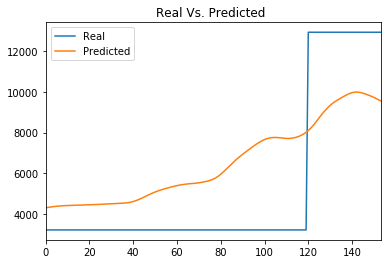

In [67]:
# Plot the real vs predicted values as a line chart
stocks.plot(title="Real Vs. Predicted ")